# Abstract

Given a dataset provided by the New York City Department of Education, I intended to use this datset to determine which characteristics of middle schools within NYC predicted overall student success and admission to one of 8 highly-selective public high schools (Stuyvesant, Bronx Science, etc.) within the city, referred to from now on as a **HSPHS.** However it must be noted that one of the features, school's average Specialized High Schools Admissions Test **(SHSAT)**, is a covariate within the dataset and must be analyzed as such.

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import zscore
from scipy.stats import ttest_ind

from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# The Dataset

In [2]:
df = pd.read_csv("middleSchoolData.csv")
print("Dataset Shape:", df.shape)
display(df)

Dataset Shape: (594, 24)


,dbn,school_name,applications,acceptances,per_pupil_spending,avg_class_size,asian_percent,black_percent,hispanic_percent,multiple_percent,...,effective_school_leadership,strong_family_community_ties,trust,disability_percent,poverty_percent,ESL_percent,school_size,student_achievement,reading_scores_exceed,math_scores_exceed
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,6,0,24890.0,20.15,3.3,31.8,61.3,0.9,...,2.45,3.33,2.32,36.6,97.6,7.5,333.0,2.70,0.33,0.26
1,01M140,P.S. 140 NATHAN STRAUS,6,0,23536.0,24.56,5.7,12.4,78.7,0.5,...,4.11,3.12,3.26,31.0,87.3,9.7,371.0,2.71,0.31,0.24
2,01M184,P.S. 184M SHUANG WEN,67,23,16206.0,29.69,69.4,3.7,13.5,6.1,...,2.75,3.38,2.91,16.5,67.5,15.1,684.0,4.28,0.68,0.74
3,01M188,P.S. 188 THE ISLAND SCHOOL,0,0,21960.0,24.09,1.8,29.3,66.1,0.0,...,4.99,4.99,4.99,29.1,91.5,15.9,433.0,4.54,0.28,0.24
4,01M301,"TECHNOLOGY, ARTS, AND SCIENCES STUDIO",11,0,25444.0,15.80,3.8,32.1,54.7,3.8,...,NaN,NaN,NaN,42.5,82.1,2.8,106.0,NaN,0.33,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,84X538,ICAHN CHARTER SCHOOL 5,20,1,NaN,NaN,4.1,58.0,31.0,1.3,...,3.38,3.38,3.51,6.9,65.2,0.9,319.0,3.31,0.33,0.33
590,84X703,BRONX PREPARATORY CHARTER SCHOOL,22,1,NaN,NaN,0.3,47.7,50.5,0.8,...,3.56,3.75,3.66,12.2,82.9,7.8,715.0,4.33,0.55,0.56
591,84X704,KIPP ACADEMY CHARTER SCHOOL,23,1,NaN,NaN,0.2,41.3,56.5,1.4,...,3.01,2.15,3.06,17.5,87.4,10.8,1074.0,2.98,0.60,0.61
592,84X706,HARRIET TUBMAN CHARTER SCHOOL,24,1,NaN,NaN,0.4,62.9,34.6,1.3,...,NaN,NaN,NaN,8.8,79.1,11.2,680.0,2.87,0.69,0.73


The dataset was provided by the New York City Department of Education and it contains data from all 594 middle schools within New York City, including 485 public schools and 109 charter schools.

# Foundational Analysis

## Correlation Between Number of Applications and HSPHS Admission

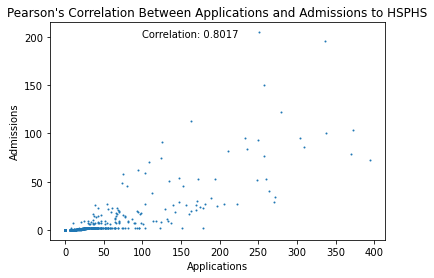

Pearson's product-moment correlation coefficient: 0.80173


In [3]:
# Determine Pearson's product-moment correlation coefficient
corr = df["applications"].corr(df["acceptances"])
# Plot the Pearson's r for applications and admissions
plt.plot(df["applications"], df["acceptances"], "o", markersize = 1)
plt.title("Pearson's Correlation Between Applications and Admissions to HSPHS")
plt.xlabel("Applications")
plt.ylabel("Admissions")
plt.text(100, 200, f'Correlation: {corr:.4f}')
plt.show()

print(f"Pearson's product-moment correlation coefficient: {corr:.5f}")

Within the relationship between applications and HSPHS admission, the correlation constant was approximately **0.802** which suggested that there was an incredibly **strong positive correlation** between raw number of applications and subsequent admission to a HSPHS. However this doesn't paint the complete picture so I wanted to see the relationship between **raw number of applications** and **application rate.**

## Raw Number of Applications vs Application Rate as Predictor for HSPHS Admission

In [4]:
# Create a new column in the DataFrame to represent Application Rate
df["application_rate"] = df["applications"] / df["school_size"]
# Determine Pearson's r correlation between application rate and acceptances
app_rate_corr = df["application_rate"].corr(df["acceptances"])
# Compare the correlations between number of applciations and application rate
print(f"Raw Applications Correlation: {corr:.4f},",
      f"Application Rate Correlation: {app_rate_corr:.4f}")

Raw Applications Correlation: 0.8017, Application Rate Correlation: 0.6588


Application rate has a correlation constant of approximately 0.6588 while raw number of applications has a costant of approximately 0.8017. Therefore it would be reasonable to state that raw number of applications is still the better predictor of admissions than considering application rate.

## Comparing Perception of Students and Objective School Performance

In [5]:
# Restrict dataframe to only predictors which measure objective school performance
predictors = df[["rigorous_instruction", "collaborative_teachers", "supportive_environment",
                "effective_school_leadership", "strong_family_community_ties", "trust", 
                 "student_achievement", "reading_scores_exceed", "math_scores_exceed"]]
# Pre-processing to remove NaN values within the DataFrame
predictors = predictors.dropna()

<AxesSubplot:>

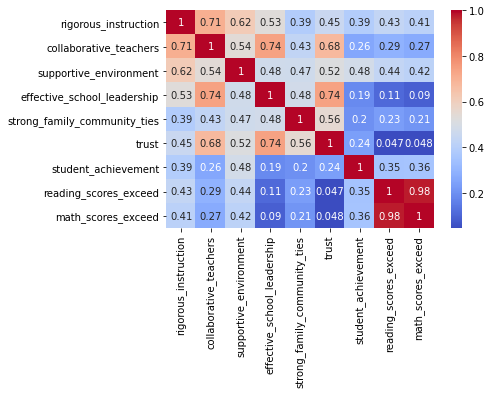

In [6]:
corr_matrix = predictors.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot = True)

## Determining if School Size Affects Overall Measures of Student Success

In [7]:
# Replace NaNs within measures of student success with average
df["student_achievement"].fillna(df["student_achievement"].mean(), inplace = True)
df["reading_scores_exceed"].fillna(df["reading_scores_exceed"].mean(), inplace = True)
df["math_scores_exceed"].fillna(df["math_scores_exceed"].mean(), inplace = True)

In [8]:
# Normalize student measures of success by z-scoring the metrics
normalized = pd.DataFrame()
normalized["achieve_norm"] = zscore(df["student_achievement"])
normalized["read_norm"] = zscore(df["reading_scores_exceed"])
normalized["math_norm"] = zscore(df["math_scores_exceed"])

# Combine average of z-scores measures of success into a single feature
df["overall_achievement"] = (normalized["achieve_norm"] + normalized["read_norm"] 
                             + normalized["math_norm"]) / 3

# Define what constitutes a small school vs a large school (median school size)
small_school = df[df["school_size"] < df["school_size"].median()]["overall_achievement"]
large_school = df[df["school_size"] >= df["school_size"].median()]["overall_achievement"]

# Conduct a two-sample t-test to determine whether overall 
# achievement differs from small and large schools
t, p = ttest_ind(small_school, large_school)
# Display the t and p-value from the two-sample t-test
print("t: ", t)
print("p-value: ", p)

t:  -8.466237279838426
p-value:  2.0130221323123662e-16


After conducting the two-sample t-test between small and large schools, we are given two test statistics to analyze. We start with the t-value obtained from the test, -8.4662. This t-value suggests that this sample mean is slightly below the hypothesized value of the population mean. However the extremely low p-value makes us confident in stating that we can reject the null hypothesis ($H_0$), in this case being that there is no difference in average achievement between small and large schools. In this case we can move to accept the alternative hypothesis ($H_a$) that there is a difference in the average achievement of students between small and large schools. The level of significance we want in this instance would be below an alpha $\alpha$ of 0.05, which basically is the probability of us making a Type I error. In this case we have an incredibly low $\alpha$ so we can be quite confident that there is a difference between sizes of schools.

# Individual Schools and Student Success Features Analysis

## School with the highest HSPHS *per student* acceptance rate

In [9]:
# Calculate the overall acceptance rate then normalize by school size
df["acceptance_rate"] = (df["acceptances"] / df["school_size"]) * 100

# Sort schools by normalized acceptance rate in descending order
sort_schools = df.sort_values(by = "acceptance_rate", ascending = False)
school_name, acceptance_rate = sort_schools[["school_name", "acceptance_rate"]].iloc[0]

# Display the school with the highest acceptance rate
print(f"The school with the highest HSPHS acceptance rate is: \n{school_name}",
      "with an acceptance rate of {acceptance_rate:.2f}%.")

The school with the highest HSPHS acceptance rate is: 
THE CHRISTA MCAULIFFE SCHOOL\I.S. 187 with an acceptance rate of {acceptance_rate:.2f}%.


## Proportion of Schools Which Account for 90% of Students Accepted to HSPHS

In [10]:
# Calculate total number of students accepted in the DataFrame
total_acceptance = sum(df["acceptances"])

# Create a new DataFrame which is softed by number of HSPHS acceptances
acceptance_df = df.sort_values(by = ["acceptances"], ascending = False)

# Create counter variable for total current sum and number of schools
cumulative_sum = 0
num_schools = 0

# Loop through the sorted DataFrame and add acceptances to cumulative sum
for index, row in acceptance_df.iterrows():
    cumulative_sum += row["acceptances"]
    num_schools += 1
    # When cumulative sum equals or is greater than 90% of all acceptances, break
    if cumulative_sum >= (total_acceptance * 0.9):
        break

# The proportion of schools is the schools which account for 90% of acceptances
# divided by the total number of schools within the DataFrame
percentage_of_schools = (num_schools / len(df)) * 100
print(f"Percentage of schools accounting for 90% of HSPHS acceptance is {percentage_of_schools:.2f}%")

Percentage of schools accounting for 90% of HSPHS acceptance is 20.71%


# Clustering to Determine Characteristics that Contribute Most to Objective Achievement and HSPHS Acceptance

## Pre-processing the Dataset that will be Used for Clustering

In [11]:
# Remove features which don't contribute to target variables
cluster_df = df.drop(["dbn","school_name"], axis = 1)

# Drop rows within DataFrame with missing values
cluster_df = cluster_df.dropna()

In [12]:
# Feature selection to include only features above specific correlation
correlations = cluster_df.corr()["acceptance_rate"]
relevant_features = correlations[correlations.abs() > 0.3].index.tolist()

## Incorporating the Clustering Algorithm

In [13]:
# Determine optimal number of clusters 
wcss = []
# Utilize silhouette score to evaluate cluster quality
silhouette = []

# Loop through various values of clusters
for i in range(2,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(cluster_df)
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(cluster_df, kmeans.labels_))

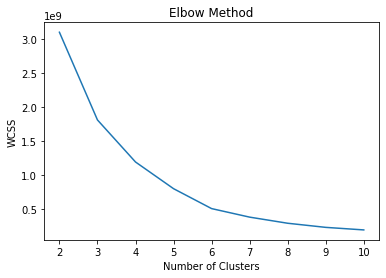

In [14]:
# Plot the within-cluster sum of squares along with elbow method
plt.plot(range(2, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show();

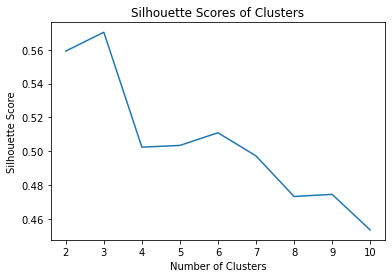

In [15]:
# Plot the silhouette score for the number of clusters
plt.plot(range(2, 11), silhouette)
plt.title("Silhouette Scores of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show();

The Elbow Method and the Silhouette Score suggests that the optimal number of clusters for the dataset is 4.

In [16]:
# Create a new DataFrame with only relevant features
relevant_df = cluster_df.loc[:, relevant_features]

# Fit a clustering algorithm onto the dataset of relevant features
kmeans = KMeans(n_clusters = 4, random_state = 17)
kmeans.fit(relevant_df)

KMeans(n_clusters=4, random_state=17)

In [17]:
# Reduce dimensionality and determine top two principal components
pca = PCA()
principal_components = pca.fit_transform(cluster_df)

# Display the total variance explained by most significant two principal components
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_[:2]):.4f}")

Total Variance Explained: 0.9997


In [18]:
# Interpret the results
cluster_df["Cluster"] = kmeans.labels_
cluster_means = cluster_df.groupby("Cluster").mean()
print(cluster_means)

         applications  acceptances  per_pupil_spending  avg_class_size  \
Cluster                                                                  
0           23.099010     2.470297        20953.633663       21.041139   
1          282.666667    89.380952        16560.095238       26.287619   
2          117.984848    25.636364        18108.424242       25.655152   
3           18.234568     0.814815        22007.537037       21.087716   

         asian_percent  black_percent  hispanic_percent  multiple_percent  \
Cluster                                                                     
0            10.687624      45.532178         25.551485          3.005941   
1            37.780952       6.233333         25.204762          2.466667   
2            28.704545      12.365152         28.689394          2.416667   
3             3.079630      20.675926         72.278395          1.006790   

         white_percent  rigorous_instruction  ...  disability_percent  \
Cluster            

# Classification Models to Determine Features Contributing Most to Overall Student Achievement

## Initial Preprocessing of the Dataset

In [43]:
# Dataset pre-processing to remove school ID and school name
updated_df = df.drop(["dbn", "school_name"], axis = 1)

# Further pre-processing to remove any NaN or empty values
updated_df = updated_df.dropna()

# Lambda function to make target variable a binary classifier
y = updated_df["overall_achievement"].apply(lambda x:1 if x>updated_df["overall_achievement"].median() else 0)
X = updated_df.drop("overall_achievement", axis = 1)

# Split the dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## Logistic Regression and Binary Classification Prediction of HSPHS Acceptance

In [20]:
# Create an instance of a LogisticRegresison object
lr = LogisticRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict outcomes for the testing data
y_pred = lr.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Calculating Accuracy Metrics for Trained Model

In [21]:
# Calculating overall accuracy of the model
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of the model is {accuracy:.2f}%")

Accuracy of the model is 85.71%


In terms of judging the trained logistic regression model, accuracy measures the proportion of correctly classified samples by the model. Its calculated by dividing the number of correctly classified samples by the total number of samples. In this case the accuracy of the model is 83.52% which whos promise in terms of the logistic regression model correctly identifying and utilizing relevant features to make classification predictions.

However accuracy doesn't paint the entire picture as its a relatively simple measure of model performance. We are simply dividing correctly identified samples by total samples. Another metric we can utilize is the precision score of the model.

In [22]:
# Calculating precision of the model
precision = precision_score(y_test, y_pred)
print(f"Precision of the model is {precision:.2f}")

Precision of the model is 0.95


In terms of judging the trained logistic regression model, precision measures the proportion of true positives among all positive samples. This sounds complicated but its essentially just measuring the number of corectly predicted positive samples among all positive predictions, including positive predictions that were actually supposed to classified as negative. It is calculated as (True Positive) / (True Positives + False Positives)

In this instance the precision of the model is 0.77 which is a relatively high precision score. However we must analyze it in conjuction with the accuracy score, which shows that the model is biasing towards making positive predictions which could be a drawback of the logistic regression model. However we can go further in analysis of the true positives in relation to all predictions using the recall score of the model.

In [23]:
# Calculating recall of the model
recall = recall_score(y_test, y_pred)
print(f"Recall of the model is {recall:.2f}")

Recall of the model is 0.79


In terms of juding the trained logistic regression model, recall measures the proportion of true positives among all positive samples. In comparison to the precision score, recall essentially measures the true positives along with the false negatives in order to obtain a more comprehensive depiction of model performance.

In [24]:
# Calculating F1 Score of the model
f1 = f1_score(y_test, y_pred)
print(f"F1 Score for the model is {f1:.2f}")

F1 Score for the model is 0.87


### Utilizing ROC AUC to Generalize Logistic Regression Performance

In [25]:
# Predict probability of outcome variable on the test data
y_pred_prob = lr.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

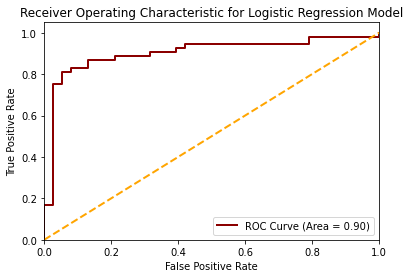

In [34]:
# Plot the ROC Curve
plt.plot(fpr, tpr, color = "darkred", lw = 2, label = "ROC Curve (Area = %0.2f)" % roc_auc)
plt.plot([0,1], [0,1], color = "orange", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Logistic Regression Model")
plt.legend(loc = "lower right")
plt.show();

The ROC, also known as the Receiver Operating Characteristic, curve is the graphical interpretation of a binary classifier's performance, which in this case represents the performance of our logistic regression model. It plots the false positive rate on the x-axis and the true positive rate on the y-axis at various differing probability thresholds.

True positive rate (TPR), also referred to as sensitivty or recall, measures proportion of true positive cases correctly identified by the classifier. False positive rate (FPR) however measures proportion of false positives incorrectly identified as positive by the classifier.

In the plot, the orange line represents the performance of a completely random classifier where the TPR and the FPR would be equal. The best models would have a ROC which is close to the top left of the graph, indicating that the model's sensitivity and specificity is high, better said as TPR being high and FPR low.

In this instance we are interested in the area under the curve (AUC) of the ROC, which is a measure of the overall performance of the logistic regression classifier. An AUC of 1.0 indicates a perfect classifier while an AUC of 0.5 indicates a random classifier. However oftentimes a perfect classifier is actually unwanted as it most likely means that the classifier overfit to the training dataset. In our model though, the ROC AUC is 0.9 which indicates that the model has incredibly strong performance overall on the dataset which it was trained on.

Overall, our logistic regression classifier seems to be quite robust in terms of classifying based on the features which students would or wouldn't be accepted to HSPHS. Now that we are confident in our model's performance however we want to determine which features the model is using in order to make these classifications.

### Identifying Model Coefficient Weights Within Logistic Regression Model

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


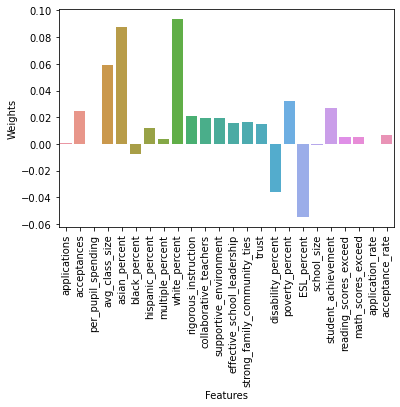

In [68]:
# Store coefficients and features of logistic regression model
coefficients = np.squeeze(lr.coef_)
feature_names = X.columns.values

# Create a bar chart of the coefficients
bar = sns.barplot(feature_names, coefficients)

# Set the bar plot and display it
bar.set(xlabel = "Features", ylabel = "Weights")
bar.set_xticklabels(bar.get_xticklabels(), rotation = 90)
plt.show();

## Support Vector Machine to Determine Features of Overall Student Success

### Initial Classification of Dataset using Decision Tree Classifier

In [27]:
# Using Decision Tree Classfier to determine feature importance
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Define feature importances
importance = tree.feature_importances_

# Loop through to only select feature importances above threshold of 0.02
features = []
for i, k in enumerate(importance):
    if k > 0.02:
        features.append(X_train.columns[i])
        
# Only keep important features for X values
X_train = X_train[features]
X_test = X_test[features]

# Scale data to improve performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# Incorporate a radial basis function (RBF) kernel onto a SVM model
svm = SVC(kernel = "rbf")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

### Evaluating Model Performance

In [29]:
# Evaluate model performance using its accuracy score
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The model has an accuracy score of {accuracy:.2f}%")

The model has an accuracy score of 98.90%


The support vector machine has a shockingly high accuracy so I'd want to analyze performance of the model with a confusion matrix also. This would allow me to analyze true positive and false positive rates which could help in understanding true model accuracy.

In [30]:
# Evaluate model performance using a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(f"The Confusion Matrix for the model is {confusion}")

The Confusion Matrix for the model is [[38  0]
 [ 1 52]]


Overall the support vector machine model built on the dataset is incredibly accurate in terms of being a comprehensive model for determining overall student success. The accuracy score of 96.7% is quite surprising as it means that the true positive rate is quite high. However we still had to consider the confusion matrix to get the complete picture. The confusion matrix gives us a better idea of the overall accuracy, with the confusion matrix showing very high true positive and false negative rates. Overall this shows the support vector machine created on the dataset is relatively robust, especially considering performance was measured on the testing dataset.

# Summary

## Initial Thoughts

After analyzing the dataset, many of the features I originally thought would play a part in both student and school performance actually were not as correlated as I had believed they would be. An example of this would be the lack of correlation between student perception of school and that school's overall performance. Features such as availability of resources, which included factors such as smaller class sizes, also didn't have as much correlation with overall objective measures of success as I had originally thought it would.

However on the other end of the spectrum, I was surprised to find that pure number of applications to HSPHS had a significantly higher correlation constant than the normalized application rate of schools.

## Educational Recommendations for the NYCDOE

Regarding initial recommendations for the New York City Department of Education, I would first inquire about what metrics of student success we wanted to work on. Withint this analysis, I focused on two measures of student sucess, overall student achievement defined as scores on standardized tests and grades as well as acceptance into highly selective public high schools (HSPHS). 

In terms of overall student success, one of the most important factors to consider is per pupil spending. Therefore I would push for schools to push for high per pupil spending within the curriculum as this feature contributed more significantly to the model predicting overall student success than other factors of material availability. 

However in regards to acceptance into HSPHS, I would recommend schools to work on generating more interest into applying for these schools. This is because total number of applicants to these highly selective schools was the most important feature within the dataset in terms of determining whether a student was accepted. And the disparity between this feature and the rest of the features within the dataset was so dramatic that this individual factor contributed most of the feature weight within the trained model. Therefore this factor would be the one factor that should be disproportionately focused on in order to facilitate student acceptances to these schools.